# Neural Style Transfer

If you are a photography enthusiast,
you may be familiar with the filter.
It can change the color style of photos
so that landscape photos become sharper
or portrait photos have whitened skins.
However,
one filter usually only changes
one aspect of the photo.
To apply an ideal style
to a photo,
you probably need to
try many different filter combinations.
This process is
as complex as tuning the hyperparameters of a model.

In this section, we will
leverage layerwise representations of a CNN
to automatically apply the style of one image
to another image, i.e., *style transfer* :cite:`Gatys.Ecker.Bethge.2016`.
This task needs two input images:
one is the *content image* and
the other is the *style image*.
We will use neural networks
to modify the content image
to make it close to the style image in style.
For example,
the content image in :numref:`fig_style_transfer` is a landscape photo taken by us
in Mount Rainier National Park in the suburbs of Seattle, while the style image is an oil painting
with the theme of autumn oak trees.
In the output synthesized image,
the oil brush strokes of the style image
are applied, leading to more vivid colors,
while preserving the main shape of the objects
in the content image.

![Given content and style images, style transfer outputs a synthesized image.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/style-transfer.svg?raw=1)
:label:`fig_style_transfer`

* cf. [StyleGAN](https://arxiv.org/pdf/1812.04948.pdf)

## Method

:numref:`fig_style_transfer_model` illustrates
the CNN-based style transfer method with a simplified example.
First, we initialize the synthesized image,
for example, into the content image.
This synthesized image is the only variable that needs to be updated during the style transfer process,
i.e., the model parameters to be updated during training.
Then we choose a pretrained CNN
to extract image features and freeze its
model parameters during training.
This deep CNN uses multiple layers
to extract
hierarchical features for images.
We can choose the output of some of these layers as content features or style features.
Take :numref:`fig_style_transfer_model` as an example.
The pretrained neural network here has 3 convolutional layers,
where the second layer outputs the content features,
and the first and third layers output the style features.

![CNN-based style transfer process. Solid lines show the direction of forward propagation and dotted lines show backward propagation. ](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/neural-style.svg?raw=1)
:label:`fig_style_transfer_model`

Next, we calculate the loss function of style transfer through forward propagation (direction of solid arrows), and update the model parameters (the synthesized image for output) through backpropagation (direction of dashed arrows).
The loss function commonly used in style transfer consists of three parts:
(i) *content loss* makes the synthesized image and the content image close in content features;
(ii) *style loss* makes the synthesized image and style image close in style features;
and (iii) *total variation loss* helps to reduce the noise in the synthesized image.
Finally, when the model training is over, we output the model parameters of the style transfer to generate
the final synthesized image.

> 1. 합성된 이미지를 만든다.
  - 처음은 content image로 시작
  - 이 이미지(X)는 학습되는 유일한 변수이다. 
  - 미리 학습된 CNN 모델을 가지고 CNN의 파라미터는 고정을 시킨 후 X에서 feature extract
> 2. Loss 계산
  - Forward propagation에서 Loss를 계산하고, Backward propagation으로 parameter(여기서는 X의 변수)를 업데이트 
  - loss의 종류
    + content loss: 합성이미지와 content image의 content feature 관점에서의 차이 (`content_loss`)
    + style loss: 합성이미지와 style image의 style feature 관점에서의 차이 (`style_loss`) - Use Gram matrix
    + total variation loss: 합성이미지에서 noise를 감소 시킴 (`tv_loss`)
> 3. 합성이미지 생성
  - 학습된 파라미터를 이용해서 합성 이미지 생성

In the following,
we will explain the technical details of style transfer via a concrete experiment.


## [**Reading the Content and Style Images**]

First, we read the content and style images.
From their printed coordinate axes,
we can tell that these images have different sizes.


In [ ]:
!pwd
!mkdir img
!wget https://github.com/d2l-ai/d2l-en/raw/master/img/autumn-oak.jpg -P img/
!wget https://github.com/d2l-ai/d2l-en/raw/master/img/rainier.jpg -P img/

/content
--2022-01-25 03:31:24--  https://github.com/d2l-ai/d2l-en/raw/master/img/autumn-oak.jpg
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/autumn-oak.jpg [following]
--2022-01-25 03:31:24--  https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/autumn-oak.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2850502 (2.7M) [image/jpeg]
Saving to: ‘img/autumn-oak.jpg’

autumn-oak.jpg      100%[===================>]   2.72M  --.-KB/s    in 0.04s   

2022-01-25 03:31:24 (72.3 MB/s) - ‘img/autumn-oak.jpg’ saved [2850502/2850502]

--2022-01-25 03:31:24--  https:/

In [ ]:
from IPython import display

from matplotlib import pyplot as plt  # pip install matplotlib
from PIL import Image                 # pip install pillow

import torch
import torchvision
from torch import nn

display.set_matplotlib_formats('svg') # Set the image format we want the notebook use for matplotlib plots e.g. pdf, retina

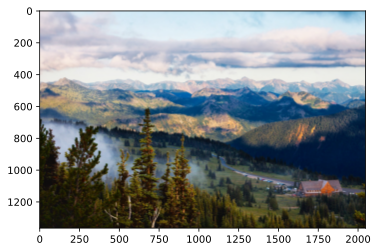

In [ ]:
content_img = Image.open('img/rainier.jpg')
plt.imshow(content_img)

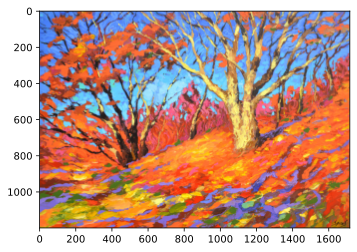

In [ ]:
style_img = Image.open('img/autumn-oak.jpg')
plt.imshow(style_img)

## [**Preprocessing and Postprocessing**]

Below, we define two functions for preprocessing and postprocessing images.

* The `preprocess` function 
  - standardizes each of the three RGB channels of the input image
  - transforms the results into the CNN input format.

* The `postprocess` function 
  - restores the pixel values in the output image to their original values before standardization
  
Since the image printing function requires that each pixel has a floating point value from 0 to 1,
we replace any value smaller than 0 or greater than 1 with 0 or 1, respectively.


In [ ]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

* Reference

  -https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

In [ ]:
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0) 

* `torchvision.transforms.Compose()`
  - Composes several transforms together. 

* `torchvision.transform.Resize()`
  - Resize the input image to the given size. If the image is torch Tensor, it is expected to have […, H, W] shape, where … means an arbitrary number of leading dimensions
  
* `torchvision.transform.ToTensor()`
  - Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] 

In [ ]:
def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

* `torch.clamp()`
  - Clamps all elements in input into the range [ min, max ]. 

## [**Extracting Features**]

We use the VGG-19 model pretrained on the ImageNet dataset to extract image features :cite:`Gatys.Ecker.Bethge.2016`.


In [ ]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In order to extract the content features and style features of the image, we can select the output of certain layers in the VGG network.
Generally speaking, the closer to the input layer, the easier to extract details of the image, and vice versa, the easier to extract the global information of the image. In order to avoid excessively
retaining the details of the content image in the synthesized image,
we choose a VGG layer that is closer to the output as the *content layer* to output the content features of the image.
We also select the output of different VGG layers for extracting local and global style features.
These layers are also called *style layers*.
As mentioned in :numref:`sec_vgg`,
the VGG network uses 5 convolutional blocks.
In the experiment, we choose the last convolutional layer of the fourth convolutional block as the content layer, and the first convolutional layer of each convolutional block as the style layer.
The indices of these layers can be obtained by printing the `pretrained_net` instance.


> * input에 가까운 layer일수록 이미지의 세부사항을 추출하는데 유리
> * output에 가까운 layer일수록 이미지의 전체 정보를 추출하는데 유리
> * VGG는 5개의 convolution block을 가지고 있다. 
> * content layer 
  - 4번째 convolution block의 마지막 convolution layer
> * style layers
  - 각 convolution block의 처음 convolution layer
  - local style layer
  - global style layer

In [ ]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

When extracting features using VGG layers,
we only need to use all those
from the input layer to the content layer or style layer that is closest to the output layer.
Let us construct a new network instance `net`, which only retains all the VGG layers to be
used for feature extraction.


In [ ]:
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])


In [ ]:
# def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
#     layers: List[nn.Module] = []
#     in_channels = 3
#     for v in cfg:
#         if v == "M":
#             layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#         else:
#             v = cast(int, v)
#             conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
#             if batch_norm:
#                 layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
#             else:
#                 layers += [conv2d, nn.ReLU(inplace=True)]
#             in_channels = v
#     return nn.Sequential(*layers)

# cfgs: Dict[str, List[Union[str, int]]] = {
#     "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
#     "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
#     "D": [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"],
#     "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"],
# }

# class VGG(nn.Module):
#   def __init__(
#   self, features: nn.Module, num_classes: int = 1000, init_weights: bool = True, dropout: float = 0.5
#       ) -> None:
#     super().__init__()
#     _log_api_usage_once(self)
#     self.features = features
#     self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
#     self.classifier = nn.Sequential(
#       nn.Linear(512 * 7 * 7, 4096),
#       nn.ReLU(True),
#       nn.Dropout(p=dropout),
#       nn.Linear(4096, 4096),
#       nn.ReLU(True),
#       nn.Dropout(p=dropout),
#       nn.Linear(4096, num_classes),
#     )
  
#   if init_weights:
#     self._initialize_weights()

#   def forward(self, x: torch.Tensor) -> torch.Tensor:
#     x = self.features(x)
#     x = self.avgpool(x)
#     x = torch.flatten(x, 1)
#     x = self.classifier(x)
#     return x

# def _vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, **kwargs: Any) -> VGG:
#     if pretrained:
#         kwargs["init_weights"] = False
#     model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
#     if pretrained:
#         state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
#         model.load_state_dict(state_dict)
#     return model

# def vgg19(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> VGG:
#     r"""VGG 19-layer model (configuration "E")
#     `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
#     The required minimum input size of the model is 32x32.
#     Args:
#         pretrained (bool): If True, returns a model pre-trained on ImageNet
#         progress (bool): If True, displays a progress bar of the download to stderr
#     """
#     return _vgg("vgg19", "E", False, pretrained, progress, **kwargs)


Given the input `X`, if we simply invoke
the forward propagation `net(X)`, we can only get the output of the last layer.
Since we also need the outputs of intermediate layers,
we need to perform layer-by-layer computation and keep
the content and style layer outputs.


In [ ]:
def extract_features(X, content_layers, style_layers):
    """ 각 layer의 결과값을 list에 넣어서 return 
    """
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

Two functions are defined below:
the `get_contents` function extracts content features from the content image,
and the `get_styles` function extracts style features from the style image.
Since there is no need to update the model parameters of the pretrained VGG during training,
we can extract the content and the style features
even before the training starts.
Since the synthesized image
is a set of model parameters to be updated
for style transfer,
we can only extract the content and style features of the synthesized image by calling the `extract_features` function during training.

> * `get_content`: content_image의 contents_Y 생성 (content loss를 계산할 때의 ground truth)
> * `get_styles`: style_image의 contents_Y 생성 (style loss를 계산할 때의 ground truth)
> * `extract_features`: content, style feature extractor


In [ ]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

## [**Defining the Loss Function**]

Now we will describe the loss function for style transfer. The loss function consists of
the content loss, style loss, and total variation loss.

### Content Loss

Similar to the loss function in linear regression,
the content loss measures the difference
in content features
between the synthesized image and the content image via
the squared loss function.
The two inputs of the squared loss function
are both
outputs of the content layer computed by the `extract_features` function.


In [ ]:
def content_loss(Y_hat, Y):
    # We detach the target content from the tree used to dynamically compute
    # the gradient: this is a stated value, not a variable. Otherwise the loss
    # will throw an error.
    return torch.square(Y_hat - Y.detach()).mean()

### Style Loss

Style loss, similar to content loss,
also uses the squared loss function to measure the difference in style between the synthesized image and the style image.
To express the style output of any style layer,
we first use the `extract_features` function to
compute the style layer output.
Suppose that the output has
1 example, $c$ channels,
height $h$, and width $w$,
we can transform this output into
matrix $\mathbf{X}$ with $c$ rows and $hw$ columns.
This matrix can be thought of as
the concatenation of
$c$ vectors $\mathbf{x}_1, \ldots, \mathbf{x}_c$,
each of which has a length of $hw$.
Here, vector $\mathbf{x}_i$ represents the style feature of channel $i$.

In the *Gram matrix* of these vectors $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$, element $x_{ij}$ in row $i$ and column $j$ is the dot product of vectors $\mathbf{x}_i$ and $\mathbf{x}_j$.
It represents the correlation of the style features of channels $i$ and $j$.
We use this Gram matrix to represent the style output of any style layer.
Note that when the value of $hw$ is larger,
it likely leads to larger values in the Gram matrix.
Note also that the height and width of the Gram matrix are both the number of channels $c$.
To allow style loss not to be affected
by these values,
the `gram` function below divides
the Gram matrix by the number of its elements, i.e., $chw$.


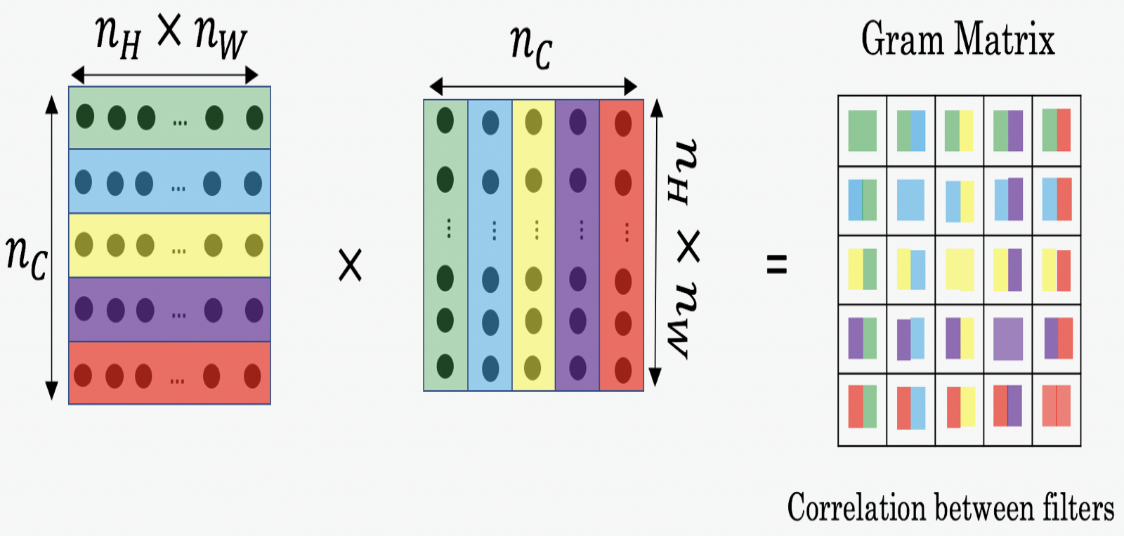

In [ ]:
def gram(X):
    # Shape of X : (C, H, W)
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

Obviously,
the two Gram matrix inputs of the squared loss function for style loss are based on
the style layer outputs for
the synthesized image and the style image.
It is assumed here that the Gram matrix `gram_Y` based on the style image has been precomputed.


In [ ]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

### Total Variation Loss

Sometimes, the learned synthesized image
has a lot of high-frequency noise,
i.e., particularly bright or dark pixels.
One common noise reduction method is
*total variation denoising*.
Denote by $x_{i, j}$ the pixel value at coordinate $(i, j)$.
Reducing total variation loss

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$

makes values of neighboring pixels on the synthesized image closer.


In [ ]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

### Loss Function

[**The loss function of style transfer is the weighted sum of content loss, style loss, and total variation loss**].
By adjusting these weight hyperparameters,
we can balance among
content retention,
style transfer,
and noise reduction on the synthesized image.


In [ ]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight # X가 synthesized image
    # Add up all the losses
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

## [**Initializing the Synthesized Image**]

In style transfer,
**the synthesized image is the only variable that needs to be updated during training.**
Thus, we can define a simple model, `SynthesizedImage`, and treat the synthesized image as the model parameters.
In this model, forward propagation just returns the model parameters.


In [ ]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self): # x input이 없음.
        return self.weight

Next, we define the `get_inits` function.
This function creates a synthesized image model instance and initializes it to the image `X`.
Gram matrices for the style image at various style layers, `styles_Y_gram`, are computed prior to training.


In [ ]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

* `Tensor.copy_(src, non_blocking=False) → Tensor`
  - Copies the elements from `src` into `self` tensor and returns `self`.

## [**Training**]


When training the model for style transfer,
we continuously extract
content features and style features of the synthesized image, and calculate the loss function.
Below defines the training loop.


In [ ]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.
    Defined in :numref:`sec_calculus`"""
    display.set_matplotlib_formats('svg')

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.
    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points.
    Defined in :numref:`sec_calculus`"""

    def has_one_axis(X):  # True if `X` (tensor or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X): X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)

    set_figsize(figsize)
    if axes is None: axes = d2l.plt.gca()
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()

        display.display(self.fig)
        display.clear_output(wait=True) # Wait to clear the output until new output is available to replace it.

In [ ]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

Now we [**start to train the model**].
We rescale the height and width of the content and style images to 300 by 450 pixels.
We use the content image to initialize the synthesized image.


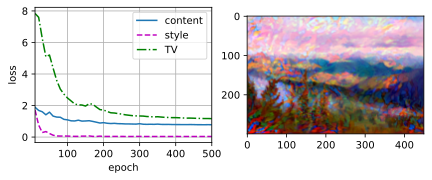

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image_shape =(300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device) # content_X: (1, 3, 300, 450)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

We can see that the synthesized image
retains the scenery and objects of the content image,
and transfers the color of the style image
at the same time.
For example,
the synthesized image has blocks of color like
those in the style image.
Some of these blocks even have the subtle texture of brush strokes.




## Summary

* The loss function commonly used in style transfer consists of three parts: (i) content loss makes the synthesized image and the content image close in content features; (ii) style loss makes the synthesized image and style image close in style features; and (iii) total variation loss helps to reduce the noise in the synthesized image.
* We can use a pretrained CNN to extract image features and minimize the loss function to continuously update the synthesized image as model parameters during training.
* We use Gram matrices to represent the style outputs from the style layers.


## Exercises

1. How does the output change when you select different content and style layers?
1. Adjust the weight hyperparameters in the loss function. Does the output retain more content or have less noise?
1. Use different content and style images. Can you create more interesting synthesized images?
1. Can we apply style transfer for text? Hint: you may refer to the survey paper by Hu et al. :cite:`Hu.Lee.Aggarwal.ea.2020`.


1. How does the output change when you select different content and style layers?

In [ ]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

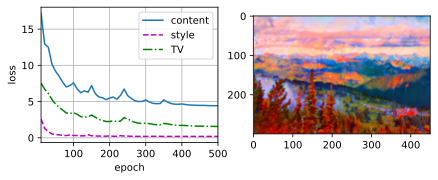

In [ ]:
style_layers, content_layers = [2, 7, 16, 25, 34], [19] # style layer을 마지막 layer로 content layer를 block의 첫번째 layer로
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])
content_weight, style_weight, tv_weight = 1, 1e3, 10
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device) # content_X: (1, 3, 300, 450)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

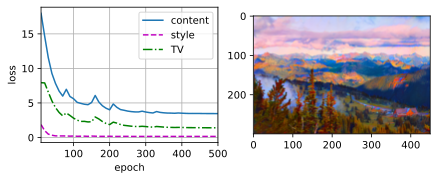

In [ ]:
style_layers, content_layers = [0, 5, 10, 19, 28], [7] # content layer를 두번째 block의 마지막 layer로 
net = nn.Sequential(*[pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)])
content_weight, style_weight, tv_weight = 1, 1e3, 10
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device) # content_X: (1, 3, 300, 450)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

2. Adjust the weight hyperparameters in the loss function. Does the output retain more content or have less noise?


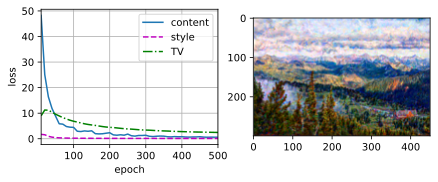

In [ ]:
content_weight, style_weight, tv_weight = 100, 1e2, 10
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

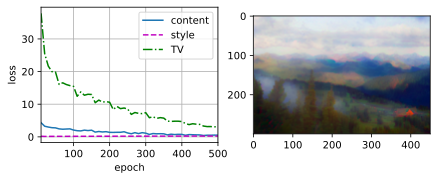

In [ ]:
content_weight, style_weight, tv_weight = 10, 1e2, 100
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

3. Use different content and style images. Can you create more interesting synthesized images?

In [45]:
![ -d img ] || mkdir img
!wget -O img/sea.jpg  --header="User-Agent: Mozilla/4.0 (compatible; MSIE 5.0; Windows NT; DigExt)" https://www.adobe.com/content/dam/cc/us/en/creative-cloud/photography/discover/landscape-photography/CODERED_B1_landscape_P2d_714x348.jpg.img.jpg 
!wget -O img/seurat.jpg  --header="User-Agent: Mozilla/4.0 (compatible; MSIE 5.0; Windows NT; DigExt)" http://upload.wikimedia.org/wikipedia/commons/0/01/Georges_Seurat_035.jpg

--2022-01-25 04:07:49--  https://www.adobe.com/content/dam/cc/us/en/creative-cloud/photography/discover/landscape-photography/CODERED_B1_landscape_P2d_714x348.jpg.img.jpg
Resolving www.adobe.com (www.adobe.com)... 23.38.194.198, 23.38.194.204, 2600:1409:6800::1728:c631, ...
Connecting to www.adobe.com (www.adobe.com)|23.38.194.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96912 (95K) [image/jpeg]
Saving to: ‘img/sea.jpg’

img/sea.jpg         100%[===================>]  94.64K  --.-KB/s    in 0.007s  

2022-01-25 04:07:49 (13.2 MB/s) - ‘img/sea.jpg’ saved [96912/96912]

--2022-01-25 04:07:49--  http://upload.wikimedia.org/wikipedia/commons/0/01/Georges_Seurat_035.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:80... connected.
HTTP request sent, awaiting response... 301 TLS Redirect
Location: https://upload.wikimedia.org/wikipedia/comm

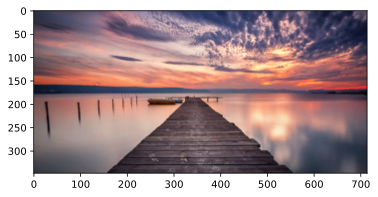

In [46]:
content_img = Image.open('img/sea.jpg')
plt.imshow(content_img)

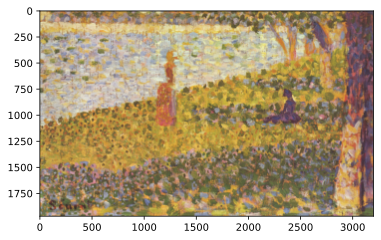

In [ ]:
style_img = Image.open('img/seurat.jpg')
plt.imshow(style_img)

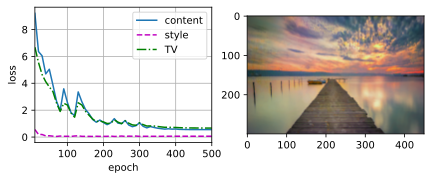

In [ ]:
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device) # content_X: (1, 3, 300, 450)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

4. Can we apply style transfer for text? Hint: you may refer to the survey paper by Hu et al. :cite:`Hu.Lee.Aggarwal.ea.2020`.

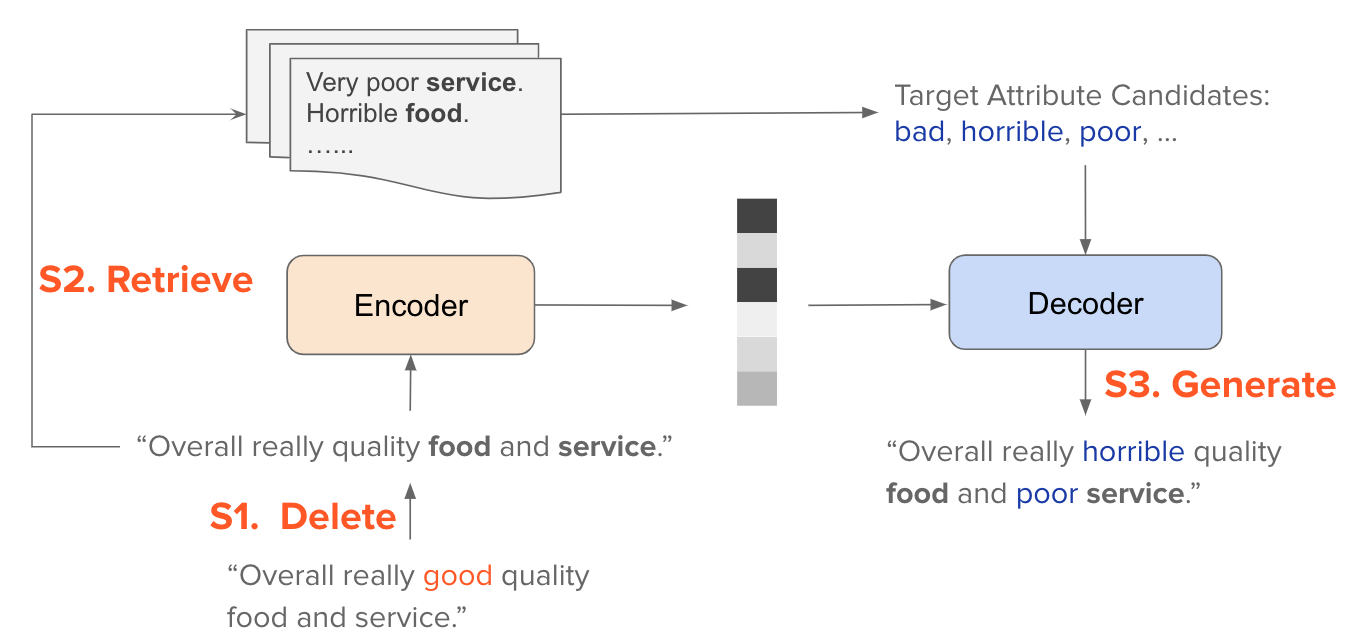

[Discussions](https://discuss.d2l.ai/t/1476)
